# Getting Started

Follow the general instructions from hw1_Q1

In [1]:
# get to the parent dir of mai_dul repo
import os

# os.chdir('../../')
os.getcwd()

'/home/ordem/PycharmProjects/MAI_DUL_WS24/homeworks/hw1'

In [2]:
# run only once at the beginning of working on hw1
# !unzip -qq homeworks/hw1/data/hw1_data.zip -d homeworks/hw1/data/

# install latest version deepul package
# !pip install -e .

In [3]:
import numpy as np
from deepul.hw1_helper import (
    # Q3
    q3ab_save_results,
)
from torch.optim import Adam
from models.IGPTModel import IGPTModel
import torch
from torch.utils.data import TensorDataset, DataLoader


# Question 3: Causal Transformer - iGPT

Now we will move onto the current most popular and widespread autoregressive model, the transformer.

## Part (a) Autoregressive Transformer on Shapes and MNIST
In this part, implement a simple Autoregressive Transformer to model binary MNIST and shapes images (same as Q2(a), but with a Transformer). 

Some additional notes about your transformer implementation:
 * iGPT uses learned positional encodings. We recommend to use those here as well. However, you may also use sinusoidal positional encodings if you wish (see the [Attention is All You Need](https://arxiv.org/abs/1706.03762) paper)
 * Autoregressive transformer always predicts the **next** token, give prior tokens. iGPT has a special **\<bos\>** or beginning of sequence token at the start of every sequence every image. Make sure to include this in your implementation as well. You can generate unconditional sample by conditioning with the **\<bos\>** token.
 * While dropout is a common feature in transformer models, you do not need to add it (but may if you wish!).
 * Prebuilt transformers exist in some frameworks (i.e. pytorch). Don't just use an off the shelf implementation as the point of the exercise is to better understand the transformer architecture. Building the transformer from the ground up (use primitives such as Linear/Dense layers, LayerNorm, GeLU, Embedding)
 * Learning rate warmup and cos learning rate decay are often used when training transformers to improve training stability and improve performance. See if this helps your model! Try 1000 steps of warmup with a cosine learning rate decay.

Paper references
* [Attention Is All You Need](https://arxiv.org/abs/1706.03762) 
* [Generative Pretraining from Pixels](https://cdn.openai.com/papers/Generative_Pretraining_from_Pixels_V2.pdf) 
* [Language Models are Unsupervised Multitask Learners](https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf)

We recommend the following network design parameters:
* $d_{model}$: 128
* heads: 4
* layers: 2
* GeLU nonlinearities

And the following hyperparameters:
* Batch size: 64 or 32 or 16 (whichever fits in your GPU)
* Learning rate: $10^{-3}$
* 15 epochs or more
* Adam Optimizer (this applies to all Transformers models trained in future parts)

**You will provide these deliverables**

1. Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2. Report the final test set performance of your final model
3. 100 samples from the final trained model



In [4]:
def q3_a(train_data, test_data, image_shape, dset_id):
    """
    train_data: A (n_train, H, W, 1) uint8 numpy array of color images with values in {0, 1}
    test_data: A (n_test, H, W, 1) uint8 numpy array of color images with values in {0, 1}
    image_shape: (H, W, 1), height, width, and # of channels of the image
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (100, H, W, 1) of samples with values in {0, 1}
    """
    batch_size = 128

    learning_rate = 0.001
    max_epochs = 25

    train_dataset = TensorDataset(torch.tensor(train_data).permute((0, 3, 1, 2)).float())
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    def transform(x):
        x_flat = torch.flatten(x, start_dim=1)
        return torch.cat((2 * torch.ones(x_flat.shape[0], 1).to(x_flat.device), x_flat), dim=1).long()

    x_test = transform(torch.tensor(test_data).permute((0, 3, 1, 2)).float())

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    test_dataset = TensorDataset(x_test)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    # x_test = x_test.to(device)

    model = IGPTModel(3, max_sequence_length=image_shape[0] * image_shape[1] + 1)
    model.to(device)

    optimizer = Adam(model.parameters(), lr=learning_rate)
    train_losses = []
    test_losses = []
    for epoch in range(max_epochs):
        batches = iter(train_loader)

        batch_train_loss = np.empty(len(batches))
        for i, [batch_x] in enumerate(batches):
            batch_x = transform(batch_x.to(device))
            logits = model.forward(batch_x)

            loss = model.loss_function(logits, batch_x)
            batch_train_loss[i] = loss

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        train_losses.append(batch_train_loss.mean().item())

        model.eval()
        with torch.no_grad():
            batch_test_loss = np.empty(len(batches))
            for i, [test_batch_x] in enumerate(test_loader):
                test_batch_x = test_batch_x.to(device)
                test_logits = model.forward(test_batch_x)
                test_loss = model.loss_function(test_logits, test_batch_x)
                batch_test_loss[i] = test_loss.item()
            test_losses.append(batch_test_loss.mean())
        model.train()
        print(f"epoch {epoch + 1}/{max_epochs}, train loss: {train_losses[-1]}, test loss: {test_losses[-1]}")
    samples = model.generate(100, device).unflatten(1, (image_shape[0], image_shape[1])).unsqueeze(-1).numpy(force=True)
    return train_losses, test_losses, samples


### Results

Once you've implemented `q3_a`, execute the cells below to visualize and save your results

epoch 1/25, train loss: 0.1879393492893475, test loss: 0.048382449622561295
epoch 2/25, train loss: 0.09333915063520758, test loss: 0.1109985891820454
epoch 3/25, train loss: 0.0824108469050105, test loss: 0.08443592034462022
epoch 4/25, train loss: 0.07755970845862133, test loss: 0.07829705253243446
epoch 5/25, train loss: 0.07305265999421841, test loss: 0.07639699283896423
epoch 6/25, train loss: 0.06947017297512148, test loss: 0.07079741463246869
epoch 7/25, train loss: 0.06670276302753425, test loss: 0.06709005011291039
epoch 8/25, train loss: 0.06482637859880924, test loss: 0.06532610362259353
epoch 9/25, train loss: 0.06282071092325013, test loss: 0.06311632402059508
epoch 10/25, train loss: 0.06080380163905097, test loss: 0.0616653453013519
epoch 11/25, train loss: 0.05957732004363362, test loss: 0.059524098502063166
epoch 12/25, train loss: 0.05849590334223538, test loss: 0.05952251261872489
epoch 13/25, train loss: 0.057450416974905064, test loss: 0.05793038378583222
epoch 14/

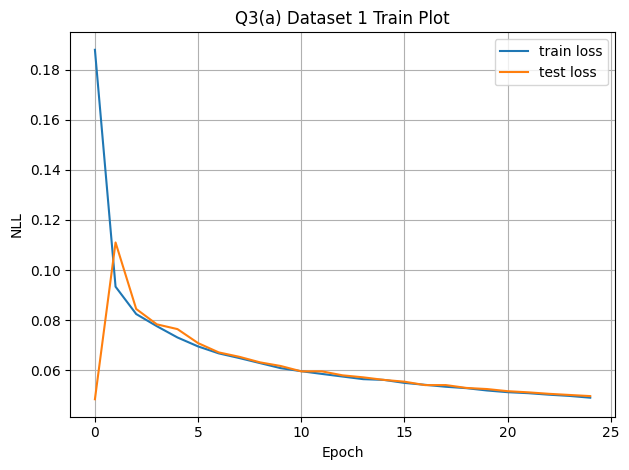

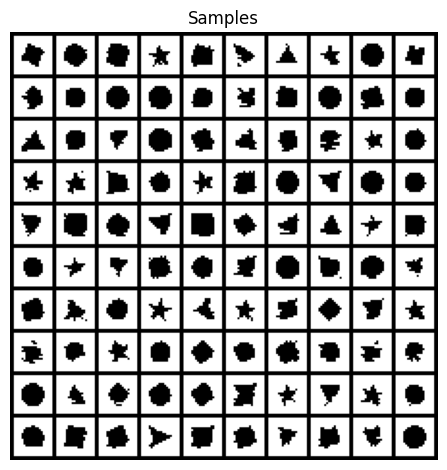

In [5]:
q3ab_save_results(1, 'a', q3_a)

epoch 1/25, train loss: 0.17736358508499447, test loss: 0.02479687345815874
epoch 2/25, train loss: 0.13737769650497925, test loss: 0.021590630843568204
epoch 3/25, train loss: 0.12471279163541062, test loss: 0.02018781997628812
epoch 4/25, train loss: 0.11871151894585157, test loss: 0.019391030025507596
epoch 5/25, train loss: 0.11455088010284184, test loss: 0.01883382326377226
epoch 6/25, train loss: 0.11172257411454532, test loss: 0.018456614903930916
epoch 7/25, train loss: 0.10946176094668252, test loss: 0.018096988087396886
epoch 8/25, train loss: 0.10741354655355279, test loss: 0.017763123472235097
epoch 9/25, train loss: 0.10544079772508475, test loss: 0.01751515909489284
epoch 10/25, train loss: 0.10376444080872323, test loss: 0.017206169839606864
epoch 11/25, train loss: 0.10209319414868792, test loss: 0.01694555043665839
epoch 12/25, train loss: 0.10064899848341179, test loss: 0.01672856301577615
epoch 13/25, train loss: 0.09919126779794185, test loss: 0.01647455567744241
ep

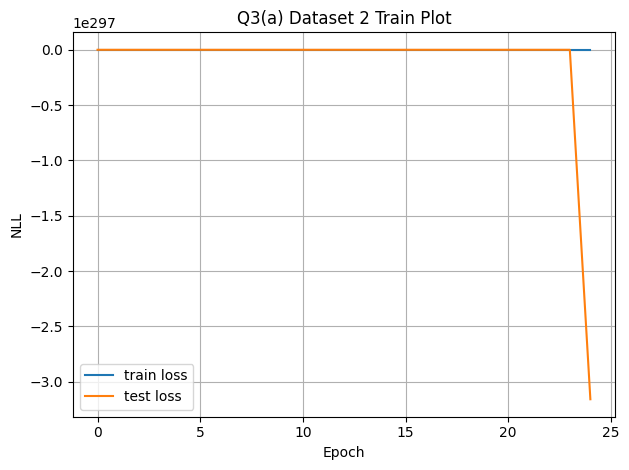

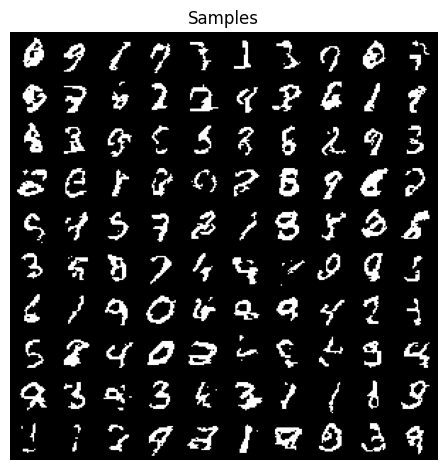

In [5]:
q3ab_save_results(2, 'a', q3_a)

## Part (b) iGPT on Colored Shapes and MNIST

Now, implement an iGPT that models color. In order to reduce the length of token sequences, iGPT models each RGB pixel as a **single** token. This effectively reduces the context length from H*W*C to just H*W. iGPT does this through a k-means clustering approach. Because our images only each can only take on 4 values (2 bits) per channel, we can represent each pixel with 64 values (6 bits). Convert the dataset into an image of tokens and train iGPT on the colored shapes and MNIST dataset.

Checkout the iGPT paper for more details: [Generative Pretraining from Pixels](https://cdn.openai.com/papers/Generative_Pretraining_from_Pixels_V2.pdf) 

Training times and hyperparameter settings should be the same as part (a), except train for longer (15 epochs)

**You will provide these deliverables**

1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model


In [17]:
from models.ColorIGPT import ColorIGPTModel


def q3_b(train_data, test_data, image_shape, dset_id):
    """
    train_data: A (n_train, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
    test_data: A (n_test, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
    image_shape: (H, W, C), height, width, and # of channels of the image
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
             used to set different hyperparameters for different datasets
  
    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (100, H, W, C) of samples with values in {0, 1, 2, 3}
    """

    batch_size = 128

    learning_rate = 0.001
    max_epochs = 25

    train_dataset = TensorDataset(torch.tensor(train_data).permute((0, 3, 1, 2)).float())
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    def transform(x):
        x_flat = torch.flatten(x, start_dim=2)
        return torch.cat((2 * torch.ones(x_flat.shape[0], 1).to(x_flat.device), x_flat), dim=1).long()

    x_test = transform(torch.tensor(test_data).permute((0, 3, 1, 2)).float())

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    x_test = x_test.to(device)

    model = ColorIGPTModel(5, max_sequence_length=20 * 20 + 1)
    model.to(device)

    optimizer = Adam(model.parameters(), lr=learning_rate)
    train_losses = []
    test_losses = []
    for epoch in range(max_epochs):
        batches = iter(train_loader)

        batch_train_loss = np.empty(len(batches))
        for i, [batch_x] in enumerate(batches):
            batch_x = transform(batch_x.to(device))
            logits = model.forward(batch_x)

            loss = model.loss_function(logits, batch_x)
            batch_train_loss[i] = loss

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        train_losses.append(batch_train_loss.mean().item())

        model.eval()
        with torch.no_grad():
            test_logits = model.forward(x_test)
            test_loss = model.loss_function(test_logits, x_test)
            test_losses.append(test_loss.item())
        model.train()
        print(f"epoch {epoch + 1}/{max_epochs}, train loss: {train_losses[-1]}, test loss: {test_losses[-1]}")
    samples = model.generate(100, device).permute((0, 2, 3, 1)).numpy(force=True)
    return train_losses, test_losses, samples

### Results

Once you've implemented `q3_b`, execute the cells below to visualize and save your results

In [18]:
q3ab_save_results(1, 'b', q3_b)

RuntimeError: Tensors must have same number of dimensions: got 2 and 3

In [ ]:
q3ab_save_results(2, 'b', q3_b)